# 1. Load dataset

In [1]:
!git clone https://github.com/e9t/nsmc.git

# 2. Load modules

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel
import torch.multiprocessing as mp

import pandas as pd
import time
import datetime
import os
from IPython.display import clear_output
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup 

In [3]:
class Args():
    def __init__(self):
        self.epochs = 5
        self.arch = 'BERT_NSMC_singleGPU'
        self.lr = 5e-5
        self.batch_size = 64
        self.gpu = 1

In [4]:
args = Args()

# 3. load model and tokenizer

In [5]:
model = BertForSequenceClassification.from_pretrained("kykim/bert-kor-base")
tokenizer = BertTokenizerFast.from_pretrained("kykim/bert-kor-base")

Some weights of the model checkpoint at kykim/bert-kor-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

# 4. load dataset

In [6]:
class NSMCDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# load nsmc dataset
nsmc_train = pd.read_csv('./nsmc/ratings_train.txt', sep='\t', encoding='utf-8')
nsmc_test = pd.read_csv('./nsmc/ratings_test.txt', sep='\t', encoding='utf-8')

# slicing dataset
nsmc_train = nsmc_train[:50000]
nsmc_test = nsmc_test[:5000]

nsmc_train['document'] = nsmc_train['document'].apply(str)
nsmc_test['document'] = nsmc_test['document'].apply(str)


# encoding
train_encodings = tokenizer(list(nsmc_train['document']), truncation=True, padding=True)
test_encodings = tokenizer(list(nsmc_test['document']), truncation=True, padding=True)

train_dataset = NSMCDataset(train_encodings, nsmc_train['label'])
test_dataset = NSMCDataset(test_encodings, nsmc_test['label'])

In [7]:
# dataloader

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

In [8]:
next(iter(train_loader))

{'input_ids': tensor([[    2, 22593, 14592,  ...,     0,     0,     0],
         [    2, 14788, 23019,  ...,     0,     0,     0],
         [    2, 14188, 15077,  ...,     0,     0,     0],
         ...,
         [    2, 18690, 18411,  ...,     0,     0,     0],
         [    2,  2787,  8228,  ...,     0,     0,     0],
         [    2, 15077,  2016,  ...,     0,     0,     0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
         1, 1, 1, 1, 1, 0, 0, 0, 1, 0,

# 6. train and test

In [9]:
# define optimizer and scheduler 

# layerNorm and bias do not trained
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

# scheduler reference => https://huggingface.co/transformers/main_classes/optimizer_schedules.html#transformers.get_linear_schedule_with_warmup
# using scheduler 
optimizer = AdamW(optimizer_grouped_parameters, lr=args.lr)
scheduler = get_linear_schedule_with_warmup(optimizer, len(train_loader) * args.epochs // 8, len(train_loader)*args.epochs)

In [10]:
len(train_loader)

157

In [11]:
# training
# Single GPU

torch.cuda.empty_cache()

writer = SummaryWriter(f'./runs/{args.arch}')
print_train = len(train_loader) // 10
total_epoch_start = time.time()

# for load model
best_acc = 0
best_model_name = ''

# for plot train and test loss
train_iter_list = []
train_loss_list = []
train_acc_list = []
test_iter_list = []
test_loss_list = []
test_acc_list = []
for epoch in range(args.epochs):
    model.train()
    model.cuda(args.gpu)
    
    train_loss = 0
    correct = 0
    total = 0
    print('====================================================')
    print('=================== Training =======================')
    print('====================================================')

    epoch_start = time.time()
    for idx, batch in enumerate(train_loader):
        start = time.time()
        inputs = {k: v.cuda(args.gpu) for k, v in batch.items()}
        outputs = model(**inputs)
        
        optimizer.zero_grad()
        outputs.loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_loss += outputs.loss.item()
        total += inputs['labels'].size(0)
        correct += inputs['labels'].eq(outputs.logits.argmax(axis=1)).sum().item()
        
        acc = 100 * correct / total
        batch_time = time.time() - start
        
        train_iter_list.append(epoch * len(train_loader) + idx)
        train_loss_list.append(outputs.loss.item())
        train_acc_list.append(acc)
        if idx % print_train == 0:
            print(f'Epoch: {epoch} \n'
                  f'total_steps: {epoch * len(train_loader) + idx} \n'
                  f'loss: {train_loss / (idx+1):.3f} \n'
                  f'acc : {acc:.3f} \n'
                  f'batch_time : {batch_time} \n'
                  )
        writer.add_scalar('Loss/train',
                           outputs.loss.item(),
                           epoch * len(train_loader) + idx)
        writer.add_scalars('Loss', 
                           {'Train_Loss': outputs.loss.item()}, 
                          epoch * len(train_loader) + idx)
        
    
    # test
    test_loss = 0
    correct = 0
    total = 0
    model.eval()
    elapse_time = time.time() - epoch_start
    elapse_time = datetime.timedelta(seconds=elapse_time)
    print(f"Epoch training: {elapse_time}")
    clear_output(wait=True)
    # test
    print('===================================================')
    print('=================== test ==========================')
    print('===================================================')
    with torch.no_grad():
        for inputs in test_loader:
            start = time.time()
            inputs = {k: v.cuda(args.gpu) for k, v in inputs.items()}
            outputs = model(**inputs)

            total += inputs['labels'].size(0)
            correct += inputs['labels'].eq(outputs.logits.argmax(axis=1)).sum().item()
            test_loss += outputs.loss.item()

            acc = 100 * correct / total
            
        # write test result
        test_iter_list.append(epoch * len(train_loader) + idx)
        test_loss_list.append(test_loss/len(test_loader))
        test_acc_list.append(acc)
        print(f'Epoch: {epoch} \n'
              f'total_steps: {epoch * len(train_loader) + idx} \n'
              f'loss: {test_loss/len(test_loader):.3f} \n'
              f'test_acc : {acc:.3f} \n'
              )
        writer.add_scalar('Loss/test',
                           test_loss/len(test_loader),
                           epoch * len(train_loader) + idx
                           )
        writer.add_scalars('Loss', 
                           {'Test_Loss': test_loss/len(test_loader)},
                           epoch * len(train_loader) + idx
                          )
        
    print(f'Epoch {epoch} finished!. Save model')
    os.makedirs(f'./{args.arch}', exist_ok=True)
    # model parameter save per epoch. 
    torch.save(model.state_dict(), f'./{args.arch}/{epoch}_{test_loss/len(test_loader):.3f}_{acc:.3f}.pt')
    if best_acc < acc:
        best_acc = acc
        best_model_name = f'./{args.arch}/{epoch}_{test_loss/len(test_loader):.3f}_{acc:.3f}.pt'
        
print(f'Total training time: {time.time() - total_epoch_start}')

=================== test ==========================
Epoch: 4 
total_steps: 784 
loss: 0.445 
test_acc : 88.800 

Epoch 4 finished!. Save model
Total training time: 304.5348002910614


In [13]:
# train_iter_list = []
# train_loss_list = []
# train_acc_list = []
# test_iter_list = []
# test_loss_list = []
# test_acc_list = []

import matplotlib.pyplot as plt

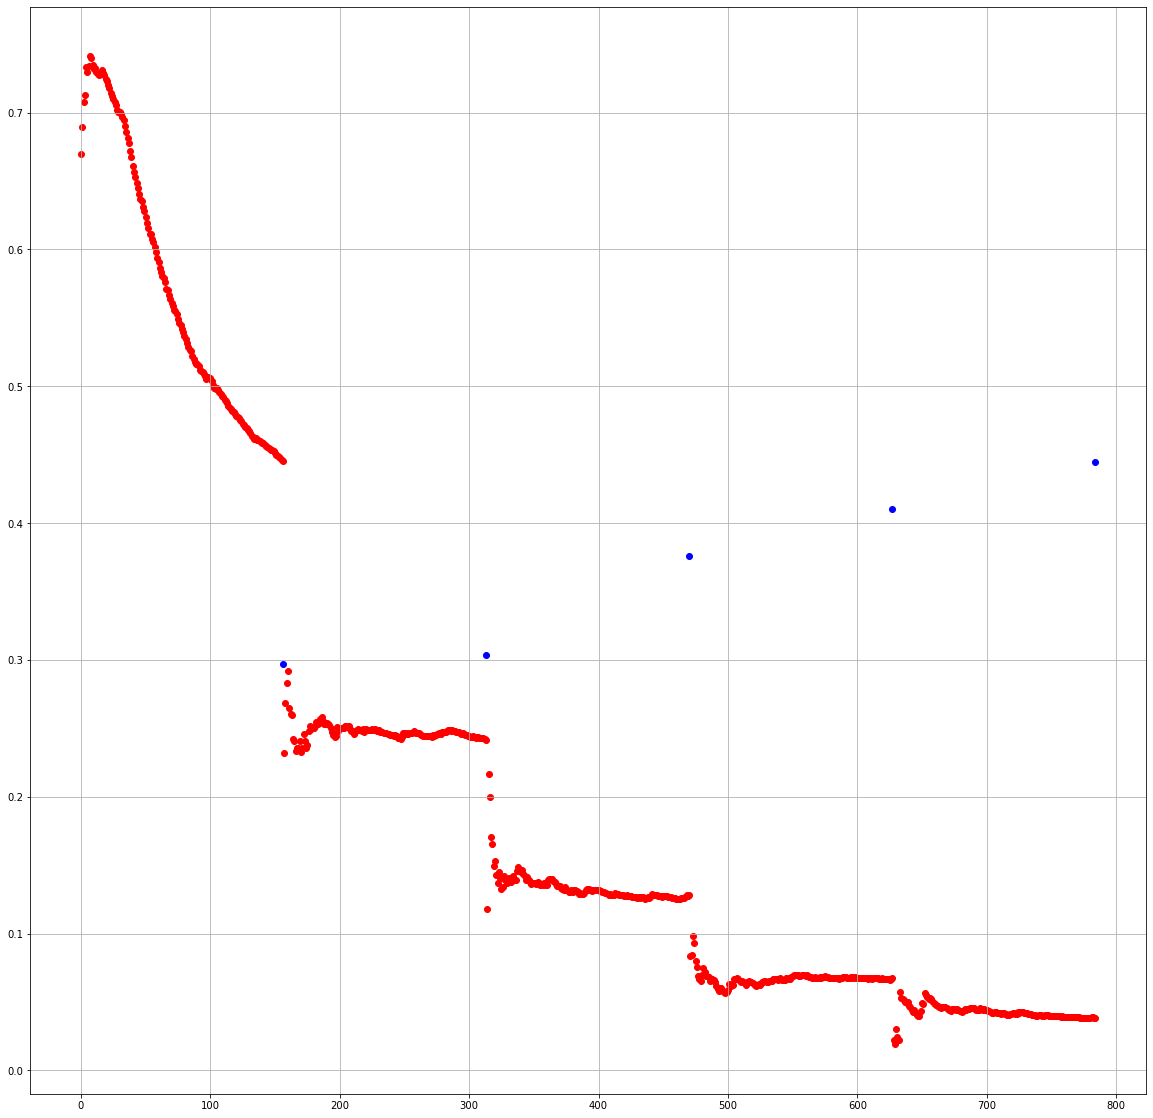

In [15]:
# plot train and test loss
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot()
ax.scatter(train_iter_list, train_loss_list, color='r', label='Train_Loss')
ax.scatter(test_iter_list, test_loss_list, color='b', label='Test_Loss')
ax.grid(True)

In [20]:
best_model_name

'./BERT_NSMC_singleGPU/4_0.445_88.800.pt'

In [22]:
best_acc

88.8

In [23]:
# load best model
model = model.load_state_dict(torch.load(best_model_name))